In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss_L1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss_L1(self, size_average=True):
        loss = torch.abs(self.hidden)
        if size_average:
            self._loss_L1 = loss.mean()
        else:
            self._loss_L1 = loss.sum()
        return self._loss_L1
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss_L1 = model.loss_L1()
            loss = model.loss(output, data) + loss_L1
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._loss_L1))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
L1_lambda = lambda p: 'L1 loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + L1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    loss_L1 = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                loss_L1[k] += m.loss_L1(size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        loss_L1[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], loss_L1[k]))
    
    lines = '\n'.join([line(k, test_loss[k], loss_L1[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.004058 32: 1.010359 64: 0.967960
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.931247 32: 0.919269 64: 0.673853
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.896322 32: 0.695619 64: 0.397209
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.858889 32: 0.456557 64: 0.287707
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.829090 32: 0.369847 64: 0.241393
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.732033 32: 0.336435 64: 0.235516
Test set:
16: loss: 0.7193	L1 loss: 0.0017
32: loss: 0.3208	L1 loss: 0.0043
64: loss: 0.2237	L1 loss: 0.0037

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.713253 32: 0.305765 64: 0.214482
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.562484 32: 0.279749 64: 0.197558
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.493218 32: 0.272183 64: 0.194030
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.425840 32: 0.245763 64: 0.175602
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.396524 32: 0.234629 64: 0.164390
Train Ep

Test set:
16: loss: 0.1260	L1 loss: 0.0013
32: loss: 0.0762	L1 loss: 0.0014
64: loss: 0.0408	L1 loss: 0.0012

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.137038 32: 0.081400 64: 0.043189
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.126073 32: 0.076050 64: 0.042667
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.115482 32: 0.068135 64: 0.038488
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.130760 32: 0.072666 64: 0.039032
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.120525 32: 0.072834 64: 0.038471
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.135929 32: 0.079737 64: 0.042791
Test set:
16: loss: 0.1233	L1 loss: 0.0012
32: loss: 0.0725	L1 loss: 0.0013
64: loss: 0.0392	L1 loss: 0.0012

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.116988 32: 0.069584 64: 0.037151
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.131026 32: 0.076646 64: 0.043623
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.128891 32: 0.076566 64: 0.042229
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.12

In [10]:
data, _ = next(iter(test_loader))
data = data.to(device)

output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.6).sum(1))
    encoded[torch.abs(encoded) < 0.6] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

eye_decoded = models['64'].decode(torch.eye(64).to(device))
eye_to_plot = ((eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

minus_eye_decoded = models['64'].decode(-1.0 * torch.eye(64).to(device))
minus_eye_to_plot = ((minus_eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()



tensor([  4,   7,   2,   8,   4,   1,   5,   6,   9,   6,   6,   7,
          2,   6,   0,   3,   3,   4,  12,   1,   6,   5,   9,   5,
          0,  12,   3,   4,   8,   4,   5,   2,   4,   6,   3,   7,
          3,   3,   5,   1,   0,   4,   6,   3,   4,   2,   8,   2,
          9,   6], device='cuda:6')


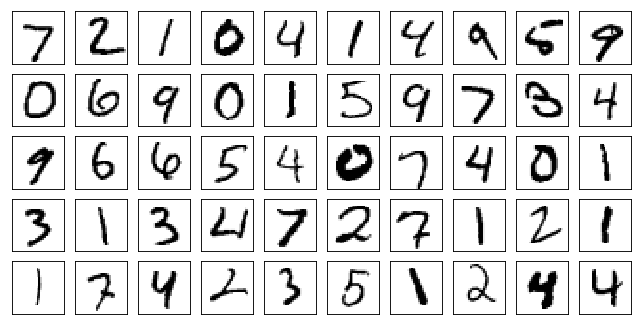

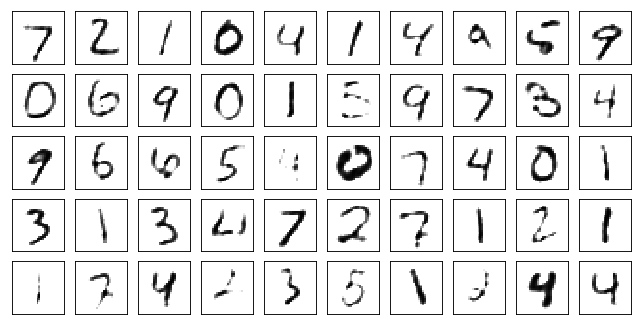

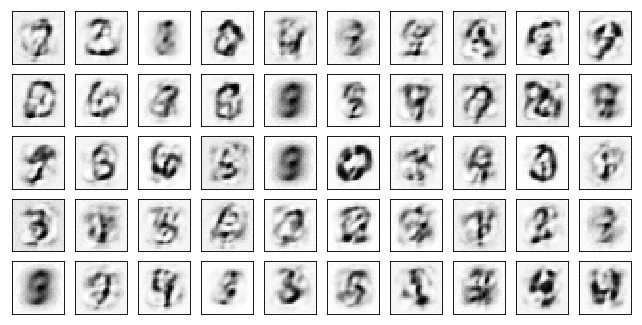

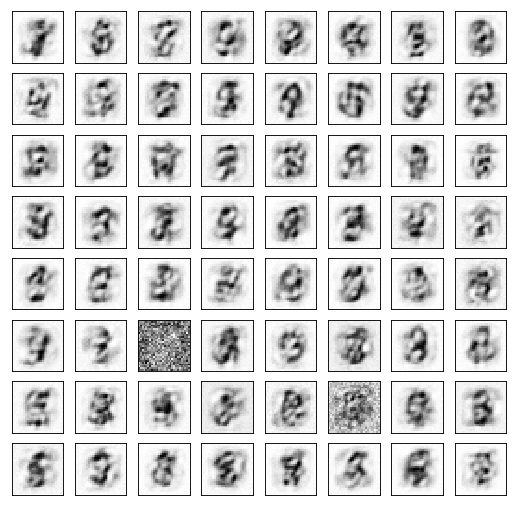

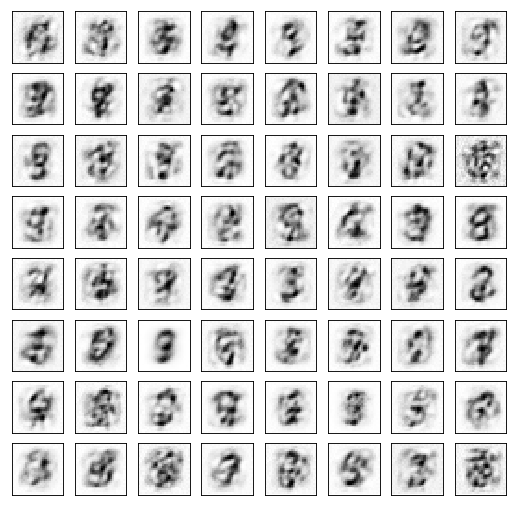

In [11]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(eye_to_plot, (8, 8))
plot_mnist(minus_eye_to_plot, (8, 8))